In [1]:
import commonsetting
from models import perceptual_network, Encoder, Class_out, Conf_out
from dataloader import CustomImageDataset, concatenate_transform_steps
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch import nn
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd


def calculate_confidence_label(y_pred):
    if y_pred <= 1/3:
        y_pred = 0
    elif y_pred >= 2/3:
        y_pred = 1
    else:
        y_pred = 0.5

    return y_pred


if __name__ == "__main__":
    pretrained_model_name   = commonsetting.pretrained_model_name
    hidden_layer_size       = commonsetting.hidden_layer_size
    hidden_activation_name  = commonsetting.hidden_activation_name
    hidden_activation       = commonsetting.hidden_activation
    hidden_dropout          = commonsetting.hidden_dropout
    resize                  = commonsetting.image_resize
    in_shape                = (1,3,resize,resize)

    SimpleCNN_args = dict(
        pretrained_model_name   = pretrained_model_name,
        hidden_layer_size       = hidden_layer_size,
        hidden_activation       = hidden_activation,
        hidden_dropout          = hidden_dropout,
        hidden_layer_type       = commonsetting.hidden_layer_type,
        output_layer_size       = commonsetting.output_layer_size,
        in_shape                = (1,3,resize,resize),
        retrain_encoder         = commonsetting.retrain_encoder,
        device                  = commonsetting.device,
        )
        

    tranformer_steps = concatenate_transform_steps(image_resize=commonsetting.image_resize, rotate=0)

    dataset_test = CustomImageDataset(commonsetting.test_dir,label_map=commonsetting.label_map , transform=tranformer_steps)
    dataloader_test = DataLoader(dataset_test, batch_size=commonsetting.batch_size, shuffle=True, num_workers=commonsetting.num_workers)
    SimpleCNN = perceptual_network(**SimpleCNN_args)
    SimpleCNN.load_state_dict(torch.load("../models/simplecnn.h5"))
    for p in SimpleCNN.parameters(): p.requires_grad = False
    # define loss function
    classification_loss = nn.BCELoss()
    # when there is no noise
    idx_layer = None
    noise_level = 0.
    # define testing dataloader
    dataset_test = CustomImageDataset(commonsetting.test_dir,label_map=commonsetting.label_map , transform=tranformer_steps)
    dataloader_test = DataLoader(dataset_test, batch_size=commonsetting.batch_size, shuffle=True, num_workers=commonsetting.num_workers)
    
    SimpleCNN.eval()
    SimpleCNN.to(commonsetting.device)
    with torch.no_grad():
        # extract features of each image
        y_true = []
        y_pred = []
        y_correct_pred = []
        confidence_out = []
        for idx_batch, (batch_image, batch_label) in tqdm(enumerate(dataloader_test)):
            batch_label = torch.vstack([1-batch_label, batch_label]).T.to(commonsetting.device)
            #记得每一次处理数据之前要做这一步
            
            features,hidden_representation,prediction, confidence = SimpleCNN(batch_image.to(commonsetting.device))
            
            temp = torch.tensor([calculate_confidence_label(item) for item in prediction[:,1].clone().detach()])

            correct_preds = torch.as_tensor(temp.clone().detach() == batch_label[:,1].clone().detach(),dtype=float)
            correct_preds = torch.vstack([1-correct_preds, correct_preds]).T.float()
            
            y_correct_pred.append(correct_preds.detach().cpu().numpy())
            y_true.append(batch_label.detach().cpu().numpy())
            y_pred.append(prediction.detach().cpu().numpy())
            confidence_out.append(confidence.detach().cpu().numpy())
    
    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    y_correct_pred = np.concatenate(y_correct_pred, axis=0)
    confidence_out = np.concatenate(confidence_out, axis=0)


47it [00:13,  3.48it/s]


In [2]:
idx = y_true[:,0] != 0.5

In [3]:
idx

array([False, False,  True, ...,  True, False,  True])

In [9]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [5]:
roc_auc_score(y_true[idx], y_pred[idx])

0.5805119999999999

In [7]:
from matplotlib import pyplot as plt

(array([ 17., 110., 273., 392., 364., 203., 112.,  24.,   2.,   3.]),
 array([0.06117282, 0.11437867, 0.16758451, 0.22079036, 0.2739962 ,
        0.32720205, 0.3804079 , 0.43361372, 0.48681957, 0.54002541,
        0.59323126]),
 <BarContainer object of 10 artists>)

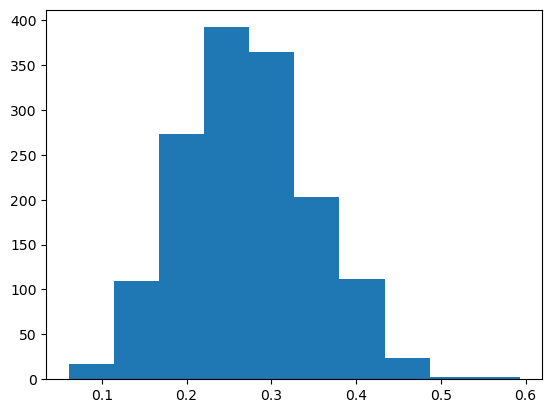

In [8]:
plt.hist(confidence_out[:,0])

In [ ]:
#the value is 1 to 0,below 0.5 is low confident, above is high confident
confidence_out